In [102]:
import collections
import sys
import math
import typing
import colorgram
import dataclasses
import cv2
import numpy as np
import matplotlib.pyplot as plt
import webcolors
from PIL import Image

sys.setrecursionlimit(1000000)

In [59]:
raw_image = cv2.imread('../images/IMG_9800.png')

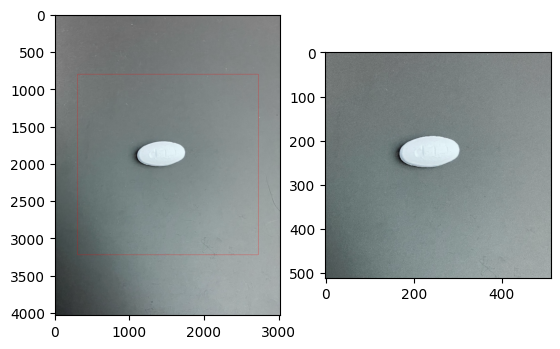

In [60]:
@dataclasses.dataclass
class Rect:
    xmin:int
    xmax:int
    ymin:int
    ymax:int

    def crop(self, image:np.ndarray) -> np.ndarray:
        if len(image.shape) > 2:
            return image[self.ymin:self.ymax, self.xmin:self.xmax, :]
        return image[self.ymin:self.ymax, self.xmin:self.xmax]


def _calcRect(shape:typing.Tuple[int], radius_ratio:float) -> Rect:
    cy, cx = shape[0]/2, shape[1]/2
    radius = radius_ratio * min(shape[:2])
    return Rect(
        xmin=int(cx-radius),
        xmax=int(cx+radius),
        ymin=int(cy-radius),
        ymax=int(cy+radius),
    )


def reshape(image:np.ndarray, size:int=512, radius_ratio:float=0.4) -> np.ndarray:
    rect = _calcRect(image.shape, radius_ratio)
    return cv2.resize(rect.crop(image), (size,size))


image = reshape(raw_image)
rect = _calcRect(raw_image.shape, 0.4)

tmp_image = raw_image.copy()
cv2.rectangle(tmp_image, (rect.xmin, rect.ymin), (rect.xmax, rect.ymax), (255,0,0), 2)

plt.subplot(121)
plt.imshow(tmp_image)
plt.subplot(122)
plt.imshow(image)

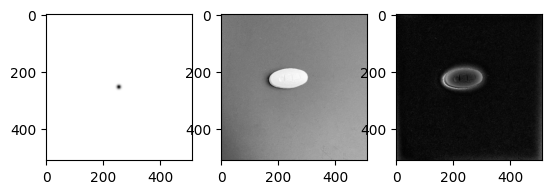

In [84]:
def freq_2d_filter(gray: np.ndarray, filter: np.ndarray) -> np.ndarray:
    if len(gray.shape) != 2:
        raise ValueError()
    fft = np.fft.fft2(np.float32(gray))
    fft_shift = np.fft.fftshift(fft)
    fft_ishift = np.fft.ifftshift(fft_shift * filter)
    ifft = np.fft.ifft2(fft_ishift)
    return np.uint8(cv2.magnitude(ifft.real, ifft.imag))


def gaussian_2d_filter(shape: typing.Tuple[int], radius: int) -> np.ndarray:
    h, w = shape[:2]
    cy, cx = h/2, w/2
    X, Y = np.meshgrid(np.linspace(1, w, w), np.linspace(1, h, h))
    out = np.exp(-(np.power(X-cx,2)+np.power(Y-cy,2))/(2*np.power(radius,2)))
    return out


gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
freq_filter = 1-gaussian_2d_filter(gray_image.shape, 5)
filtered_image = freq_2d_filter(gray_image, freq_filter)

plt.subplot(131)
plt.imshow(freq_filter, cmap='gray')
plt.subplot(132)
plt.imshow(gray_image, cmap='gray')
plt.subplot(133)
plt.imshow(filtered_image, cmap='gray')
plt.show()

(array([[222., 143., 122., ...,   0.,   0.,   0.],
        [237., 139., 132., ...,   0.,   0.,   0.],
        [258., 148., 101., ...,   0.,   0.,   0.],
        ...,
        [ 67., 234., 167., ...,   0.,   0.,   0.],
        [ 69., 212., 162., ...,   0.,   0.,   0.],
        [ 54., 222., 158., ...,   0.,   0.,   0.]]),
 array([  0. ,  13.2,  26.4,  39.6,  52.8,  66. ,  79.2,  92.4, 105.6,
        118.8, 132. ]),
 <a list of 512 BarContainer objects>)

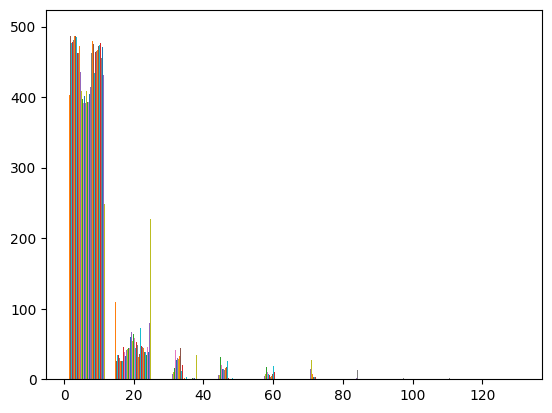

In [85]:
plt.hist(filtered_image)

Otsu's threshold value: 21.0


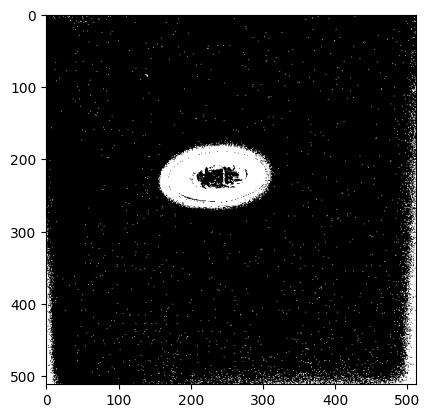

In [86]:
otsu_value, bin_image = cv2.threshold(filtered_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
print(f"Otsu's threshold value: {otsu_value}")
plt.imshow(bin_image, cmap='gray')

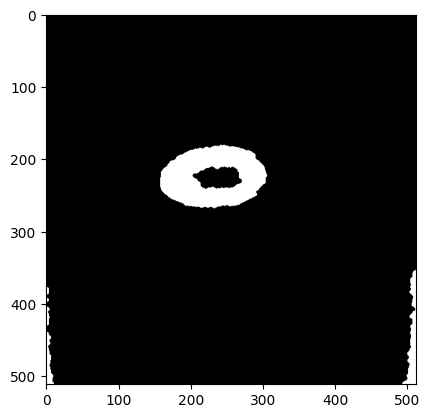

In [112]:
struct_elem = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7))
morphed_bin_image = bin_image
morphed_bin_image = cv2.morphologyEx(morphed_bin_image, cv2.MORPH_OPEN, struct_elem)
morphed_bin_image = cv2.morphologyEx(morphed_bin_image, cv2.MORPH_CLOSE, struct_elem)

plt.imshow(morphed_bin_image, cmap='gray')

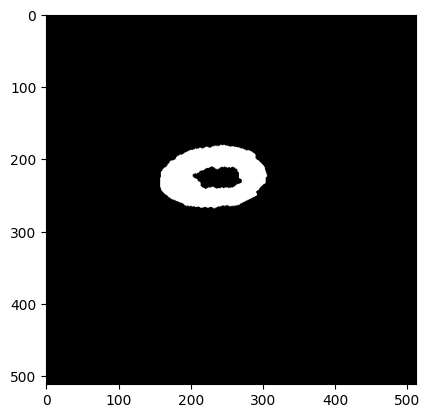

In [113]:
def dfs_remove_util(mat: np.ndarray, y:int, x:int):
    if x < 0 or y < 0 or x >= mat.shape[1] or y >= mat.shape[0]:
        return
    if not mat[y,x]:
        return
    mat[y,x] = 0
    for dx in (-1,0,1):
        for dy in (-1,0,1):
            dfs_remove_util(mat, y+dy, x+dx)


def remove_edge(bin_image: np.ndarray) -> np.ndarray:
    h,w = bin_image.shape[:2]
    q = collections.deque()
    for x in range(w):
        q.append((0,x))
        q.append((h-1,x))
    for y in range(h):
        q.append((y,0))
        q.append((y,w-1))
    while q:
        y, x = q.popleft()
        dfs_remove_util(bin_image, y, x)
    return bin_image


plt.imshow(remove_edge(morphed_bin_image), cmap='gray')


In [114]:
contours = cv2.findContours(morphed_bin_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]
print(f'{len(contours)} contours found.')

1 contours found.


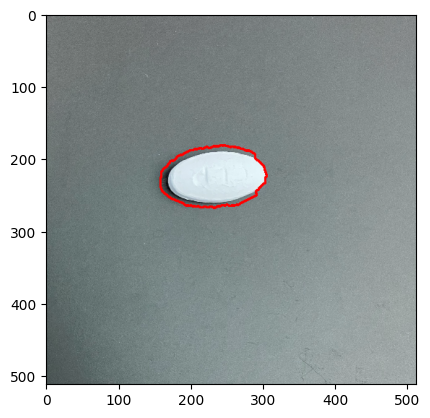

In [117]:
tmp_image = image
cv2.drawContours(tmp_image, contours, -1, (255,0,0), 2)

plt.imshow(tmp_image)